## An algorithm for human deceit

Social data has an additional layer of interest as people are not always honest with responses, which adds a further complication into inference. For example, simply asking individuals "Have you ever cheated on a test?" will surely contain some rate of dishonesty. What you can say for certain is that the true rate is less than your observed rate (assuming individuals lie *only* about *not cheating*; I cannot imagine one who would admit "Yes" to cheating when in fact they hadn't cheated). 

To present an elegant solution to circumventing this dishonesty problem, and to demonstrate Bayesian modeling, we first need to introduce the binomial distribution.

### The Binomial Distribution

The binomial distribution is one of the most popular distributions, mostly because of its simplicity and usefulness.The binomial distribution has 2 parameters: $N$, a positive integer representing $N$ trials or number of instances of potential events, and $p$, the probability of an event occurring in a single trial. Like the Poisson distribution, it is a discrete distribution, but unlike the Poisson distribution, it only weighs integers from $0$ to $N$. The mass distribution looks like:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

If $X$ is a binomial random variable with parameters $p$ and $N$, denoted $X \sim \text{Bin}(N,p)$, then $X$ is the number of events that occurred in the $N$ trials (obviously $0 \le X \le N$). The larger $p$ is (while still remaining between 0 and 1), the more events are likely to occur. The expected value of a binomial is equal to $Np$. Below we plot the mass probability distribution for varying parameters. 


In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import arviz as az
import matplotlib as mt
mt.style.use("ggplot")
import numpy as np
import pandas as pd
import pymc as pm
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


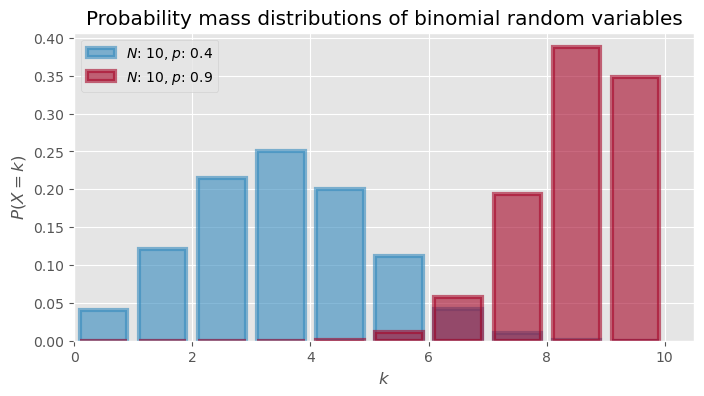

In [2]:
figsize(8, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables");

The special case when $N = 1$ corresponds to the Bernoulli distribution. There is another connection between Bernoulli and Binomial random variables. If we have $X_1, X_2, ... , X_N$ Bernoulli random variables with the same $p$, then $Z = X_1 + X_2 + ... + X_N \sim \text{Binomial}(N, p )$.

The expected value of a Bernoulli random variable is $p$. This can be seen by noting the more general Binomial random variable has expected value $Np$ and setting $N=1$.

##### Example: Cheating among students

We will use the binomial distribution to determine the frequency of students cheating during an exam. If we let $N$ be the total number of students who took the exam, and assuming each student is interviewed post-exam (answering without consequence), we will receive integer $X$ "Yes I did cheat" answers. We then find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$. 

This is a completely absurd model. No student, even with a free-pass against punishment, would admit to cheating. What we need is a better *algorithm* to ask students if they had cheated. Ideally the algorithm should encourage individuals to be honest while preserving privacy. The following proposed algorithm is a solution I greatly admire for its ingenuity and effectiveness:

> In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers. 

I call this the Privacy Algorithm. One could of course argue that the interviewers are still receiving false data since some *Yes*'s are not confessions but instead randomness, but an alternative perspective is that the researchers are discarding approximately half of their original dataset since half of the responses will be noise. But they have gained a systematic data generation process that can be modeled. Furthermore, they do not have to incorporate (perhaps somewhat naively) the possibility of deceitful answers. We can use PyMC to dig through this noisy model, and find a posterior distribution for the true frequency of liars. 

Suppose 100 students are being surveyed for cheating, and we wish to find $p$, the proportion of cheaters. There are a few ways we can model this in PyMC.  In our data-generation model, we sample $p$, the true proportion of cheaters, from a prior. Since we are quite ignorant about $p$, we will assign it a $\text{Uniform}(0,1)$ prior.

In [3]:
import pymc as pm
N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

Again, thinking of our data-generation model, we assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not. 

In [4]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, initval=np.random.binomial(1, 0.5, N))

If we carry out the algorithm, the next step that occurs is the first coin-flip each student makes. This can be modeled again by sampling 100 Bernoulli random variables with $p=1/2$: denote a 1 as a *Heads* and 0 a *Tails*.

In [5]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, initval=np.random.binomial(1, 0.5, N))
    
print(pm.draw(first_coin_flips))

[1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0
 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0]


Although *not everyone* flips a second time, we can still model the possible realization of second coin-flips:

In [6]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, initval=np.random.binomial(1, 0.5, N))

Using these variables, we can return a possible realization of the *observed proportion* of "Yes" responses. We do this using a PyMC `deterministic` variable:

In [7]:
import pytensor.tensor as at
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", at.sum(val)/float(N))

The line `fc*t_a + (1-fc)*sc` contains the heart of the Privacy algorithm. Elements in this array are 1 *if and only if* i) the first toss is heads and the student cheated or ii) the first toss is tails, and the second is heads, and are 0 else. Finally, the last line sums this vector and divides by `float(N)`, produces a proportion. 

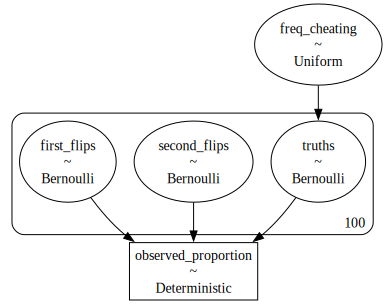

In [8]:
pm.model_to_graphviz(model)

In [9]:
model.initial_point()

{'freq_cheating_interval__': array(0.),
 'truths': array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]),
 'first_flips': array([1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]),
 'second_flips': array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 0,

Next we need a dataset. After performing our coin-flipped interviews the researchers received 35 "Yes" responses. To put this into a relative perspective, if there truly were no cheaters, we should expect to see on average 1/4 of all responses being a "Yes" (half chance of having first coin land Tails, and another half chance of having second coin land Heads), so about 25 responses in a cheat-free world. On the other hand, if *all students cheated*, we should expected to see approximately 3/4 of all responses be "Yes". 

The researchers observe a Binomial random variable, with `N = 100` and `p = observed_proportion` with `value = 35`:  

In [10]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

Below we add all the variables of interest to a `Model` container and run our black-box algorithm over the model. 

In [11]:

with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step,chains=1)
    # burned_trace = trace[15000:]
    

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]


Output()

Sampling 1 chain for 1_000 tune and 40_000 draw iterations (1_000 + 40_000 draws total) took 356 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


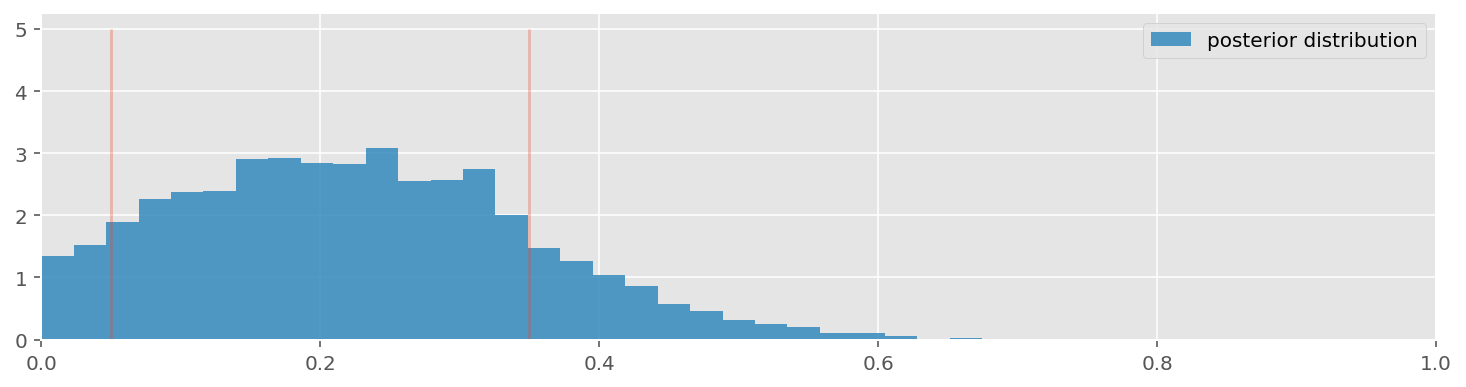

In [45]:
figsize(12.5, 3)
p_trace = np.concatenate(trace.posterior.freq_cheating.data[:,15000:]) #burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

With regards to the above plot, we are still pretty uncertain about what the true frequency of cheaters might be, but we have narrowed it down to a range between 0.05 to 0.35 (marked by the solid lines). This is pretty good, as *a priori* we had no idea how many students might have cheated (hence the uniform distribution for our prior). On the other hand, it is also pretty bad since there is a .3 length window the true value most likely lives in. Have we even gained anything, or are we still too uncertain about the true frequency? 

I would argue, yes, we have discovered something. It is implausible, according to our posterior, that there are *no cheaters*, i.e. the posterior assigns low probability to $p=0$. Since we started with an uniform prior, treating all values of $p$ as equally plausible, but the data ruled out $p=0$ as a possibility, we can be confident that there were cheaters. 

This kind of algorithm can be used to gather private information from users and be *reasonably* confident that the data, though noisy, is truthful. 



### Alternative PyMC Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes: 

\begin{align}
P(\text{"Yes"}) = & P( \text{Heads on first coin} )P( \text{cheater} ) + P( \text{Tails on first coin} )P( \text{Heads on second coin} ) \\\\
& = \frac{1}{2}p + \frac{1}{2}\frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

Thus, knowing $p$ we know the probability a student will respond "Yes". In PyMC, we can create a deterministic function to evaluate the probability of responding "Yes", given $p$:

In [4]:


with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

I could have typed `p_skewed  = 0.5*p + 0.25` instead for a one-liner, as the elementary operations of addition and scalar multiplication will implicitly create a `deterministic` variable, but I wanted to make the deterministic boilerplate explicit for clarity's sake. 

If we know the probability of respondents saying "Yes", which is `p_skewed`, and we have $N=100$ students, the number of "Yes" responses is a binomial random variable with parameters `N` and `p_skewed`.

This is where we include our observed 35 "Yes" responses. In the declaration of the `pm.Binomial`, we include `value = 35` and `observed = True`.

In [5]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)

Below we add all the variables of interest to a `Model` container and run our black-box algorithm over the model. 

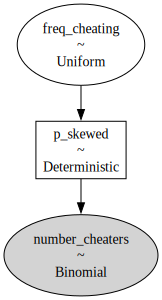

In [6]:
pm.model_to_graphviz(model)

In [8]:
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'
with model:
    # To Be Explained in Chapter 3!
    step = pm.Metropolis()
    # the new kwarg tune means drop the first 2500 unstable data
    trace = pm.sample(25000, step=step,tune=2500)
    # burned_trace = trace[2500:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]


Output()

Sampling 4 chains for 2_500 tune and 25_000 draw iterations (10_000 + 100_000 draws total) took 5 seconds.


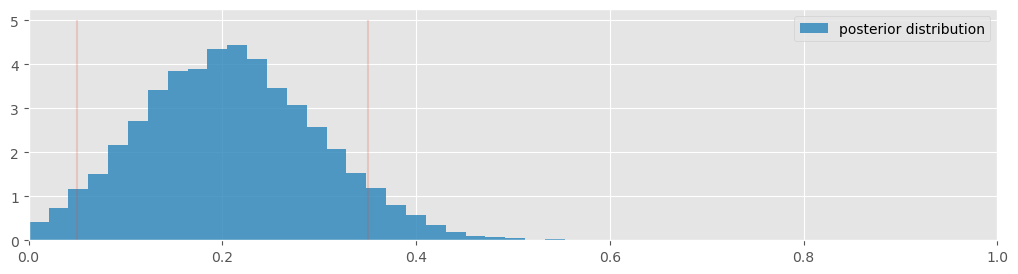

In [9]:
figsize(12.5, 3)
p_trace = np.concatenate(trace.posterior.freq_cheating.data[:,:])# burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

### More PyMC Tricks

#### Protip: Arrays of PyMC variables
There is no reason why we cannot store multiple heterogeneous PyMC variables in a Numpy array. Just remember to set the `dtype` of the array to `object` upon initialization. For example:




In [50]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

##### Exercises

1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

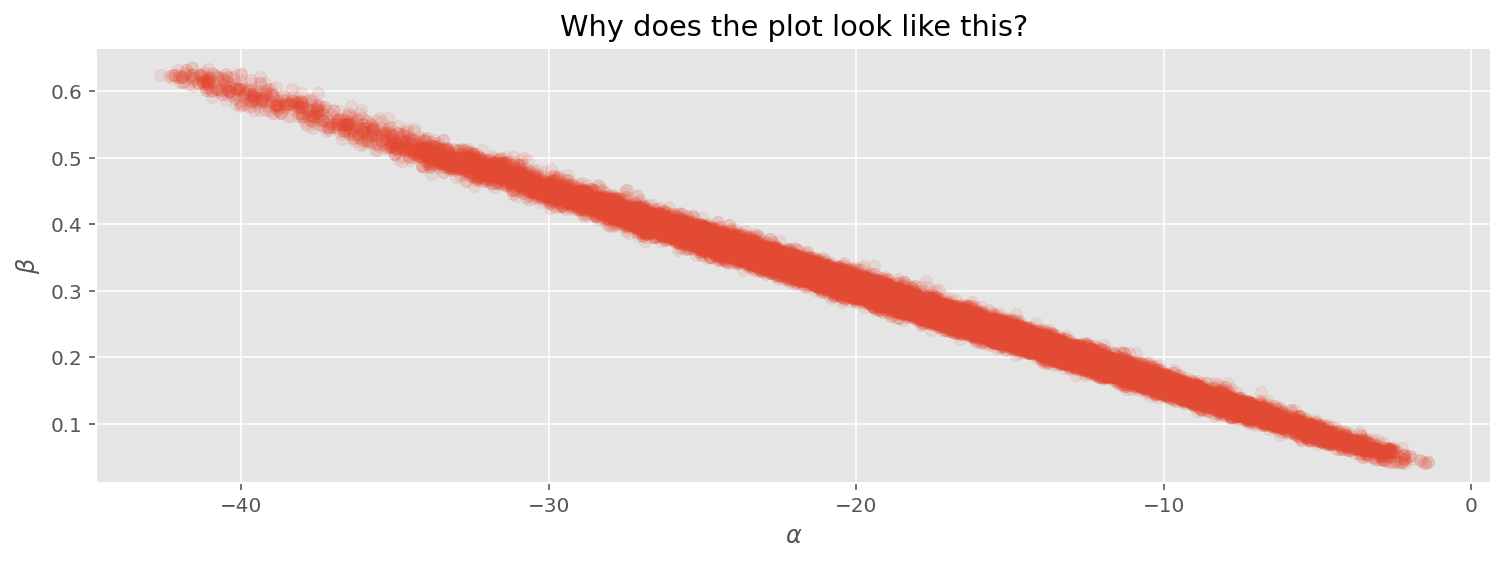

In [69]:
#type your code here.
figsize(12.5, 4)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

### References

-  [1] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.
-  [2] German Rodriguez. Datasets. In WWS509. Retrieved 30/01/2013, from <http://data.princeton.edu/wws509/datasets/#smoking>.
-  [3] McLeish, Don, and Cyntha Struthers. STATISTICS 450/850 Estimation and Hypothesis Testing. Winter 2012. Waterloo, Ontario: 2012. Print.
-  [4] Fonnesbeck, Christopher. "Building Models." PyMC-Devs. N.p., n.d. Web. 26 Feb 2013. <http://pymc-devs.github.com/pymc/modelbuilding.html>.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.
- [6] S.P. Brooks, E.A. Catchpole, and B.J.T. Morgan. Bayesian animal survival estimation. Statistical Science, 15: 357–376, 2000
- [7] Gelman, Andrew. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 2 Apr. 2013.
- [8] Greenhill, Brian, Michael D. Ward, and Audrey Sacks. "The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models." American Journal of Political Science. 55.No.4 (2011): n. page. Web. 2 Apr. 2013.

In [70]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()